## Author: Alexandru Paul Tabacaru  ;  alextabac@gmail.com
## MIT License

In [161]:
import pandas as pd
import numpy as np
from math import floor
import scipy.stats as stats
import os
import json
import random
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport
from datetime import datetime
from collections import deque
from MASS_V4 import MASS_V4
from DAMP_V2 import DAMP_V2
from datetime import datetime
import matplotlib.pyplot as plt
from importlib import reload
from data_prep import Data_Preprocess as dprep

## Paths and Data Files

In [3]:
os.getcwd()

'C:\\ALEX\\BGU\\TDA\\PROJECT\\TSAD_project'

In [4]:
data_path = "..\\..\\sensors_data"
data_folder = os.path.join(os.getcwd(), data_path)
files1 = os.listdir(data_folder)
files2 = [os.path.join(data_folder, f) for f in files1 if f.endswith("_trim.tab")]
files = [f for f in files2 if os.path.isfile(f)]
delimiter = "\t"

## Equipment digits explained:
### first digit is the server NOD number:  1, 2, 3, or 4 otherwise
### second digit is the SITE within the NOD: 0, 1, 2.
### third digit is the entity number: 0 to 6 at most
### fourth digit is the side of the entity:  0 or 1

In [250]:
import data_prep
reload(data_prep)
from data_prep import Data_Preprocess as dprep

In [252]:
data_obj = dprep(aggregate_type='min', aggregate_amount=15, feature_num=2)
data_obj.load_data(files[0], delimiter)

File loaded with 11568827 rows.


In [253]:
len(data_obj.df)

3140370

In [254]:
data_obj.prepare_series()

Preparing key series Equip2000_Feature2_mean ...
Preparing key series Equip2001_Feature2_mean ...
Preparing key series Equip2010_Feature2_mean ...
Preparing key series Equip2011_Feature2_mean ...
Preparing key series Equip2050_Feature2_mean ...
Preparing key series Equip2051_Feature2_mean ...
Preparing key series Equip2060_Feature2_mean ...
Preparing key series Equip2061_Feature2_mean ...
Preparing key series Equip2020_Feature2_mean ...
Preparing key series Equip2021_Feature2_mean ...
Preparing key series Equip2031_Feature2_mean ...
Preparing key series Equip2040_Feature2_mean ...
Preparing key series Equip2041_Feature2_mean ...
Preparing key series Equip2030_Feature2_mean ...
Preparing key series Equip2000_Feature2_std ...
Preparing key series Equip2001_Feature2_std ...
Preparing key series Equip2010_Feature2_std ...
Found two clusters or more and need split, in dataset Equip2010_Feature2_std, indx 8107, delta 1.8514249414863468.
Preparing key series Equip2011_Feature2_std ...
Prepari

In [255]:
len(data_obj.dfs)

34

In [256]:
type(data_obj.dfs)

list

In [257]:
N = 0
for df in data_obj.dfs:
    N += len(df)
print(N)

367699


In [258]:
np.mean(data_obj.dfs[5]['value'])

-7.350572582590664e-16

In [259]:
np.std(data_obj.dfs[5]['value'])

1.0000000000000002

In [260]:
len(data_obj.dfs)

34

In [263]:
data_obj.dfs[10]

,time,RUN_START_WW,Equip,series,key,value
0,2022-06-27 01:45:00,202227,Equip2031,Feature2_mean,Equip2031_Feature2_mean,0.620855
1,2022-06-27 07:00:00,202227,Equip2031,Feature2_mean,Equip2031_Feature2_mean,0.467176
2,2022-06-27 13:30:00,202227,Equip2031,Feature2_mean,Equip2031_Feature2_mean,0.159094
3,2022-06-27 14:00:00,202227,Equip2031,Feature2_mean,Equip2031_Feature2_mean,-0.148988
4,2022-06-27 17:30:00,202227,Equip2031,Feature2_mean,Equip2031_Feature2_mean,4.671594
...,...,...,...,...,...,...
11671,2022-11-24 01:15:00,202248,Equip2031,Feature2_mean,Equip2031_Feature2_mean,-0.714712
11672,2022-11-24 01:45:00,202248,Equip2031,Feature2_mean,Equip2031_Feature2_mean,0.327343
11673,2022-11-24 02:00:00,202248,Equip2031,Feature2_mean,Equip2031_Feature2_mean,0.953970
11674,2022-11-24 02:15:00,202248,Equip2031,Feature2_mean,Equip2031_Feature2_mean,-0.825175


In [264]:
for i in range(len(data_obj.dfs)):
    print(data_obj.dfs[i].loc[0, 'key'])

Equip2000_Feature2_mean
Equip2001_Feature2_mean
Equip2010_Feature2_mean
Equip2011_Feature2_mean
Equip2050_Feature2_mean
Equip2051_Feature2_mean
Equip2060_Feature2_mean
Equip2061_Feature2_mean
Equip2020_Feature2_mean
Equip2021_Feature2_mean
Equip2031_Feature2_mean
Equip2040_Feature2_mean
Equip2041_Feature2_mean
Equip2030_Feature2_mean
Equip2000_Feature2_std
Equip2001_Feature2_std
Equip2010_Feature2_std
Equip2010_Feature2_std
Equip2010_Feature2_std
Equip2011_Feature2_std
Equip2050_Feature2_std
Equip2051_Feature2_std
Equip2060_Feature2_std
Equip2061_Feature2_std
Equip2020_Feature2_std
Equip2021_Feature2_std
Equip2031_Feature2_std
Equip2031_Feature2_std
Equip2031_Feature2_std
Equip2031_Feature2_std
Equip2031_Feature2_std
Equip2040_Feature2_std
Equip2041_Feature2_std
Equip2030_Feature2_std


In [265]:
data_obj.dfs[5]['value']

0        1.596570
1        1.715241
2        1.372563
3        0.360406
4        2.558051
           ...   
12904   -0.978973
12905   -1.080436
12906   -1.120397
12907   -1.324339
12908   -2.736174
Name: value, Length: 12909, dtype: float64

In [239]:
circflow_mean_idx = []
for i in range(len(data_obj.dfs)):
    if 'Feature9' in data_obj.dfs[i].loc[0, 'key'] and len(data_obj.dfs[i]) > 1000:
        circflow_mean_idx.append(i)
        print(f"index {i} - key {data_obj.dfs[i].loc[0, 'key']} - len {len(data_obj.dfs[i])}")

index 24 - key Equip2060_Feature9_mean - len 10267
index 29 - key Equip2061_Feature9_mean - len 10267
index 34 - key Equip2030_Feature9_mean - len 12748
index 39 - key Equip2031_Feature9_mean - len 12748
index 49 - key Equip2010_Feature9_mean - len 14790
index 54 - key Equip2011_Feature9_mean - len 14790
index 74 - key Equip2050_Feature9_mean - len 14514
index 79 - key Equip2051_Feature9_mean - len 14514
index 84 - key Equip2000_Feature9_mean - len 15748
index 89 - key Equip2001_Feature9_mean - len 15748
index 94 - key Equip2020_Feature9_mean - len 14944
index 99 - key Equip2021_Feature9_mean - len 14944
index 116 - key Equip2040_Feature9_mean - len 14319
index 121 - key Equip2041_Feature9_mean - len 9999
index 122 - key Equip2041_Feature9_mean - len 4320
index 123 - key Equip2041_Feature9_mean - len 14319
index 174 - key Equip2060_Feature9_std - len 10267
index 179 - key Equip2061_Feature9_std - len 10267
index 184 - key Equip2030_Feature9_std - len 12748
index 189 - key Equip2031_Fea

In [240]:
circflow_std_idx = []
for i in range(len(data_obj.dfs)):
    if 'Feature4' in data_obj.dfs[i].loc[0, 'key'] and len(data_obj.dfs[i]) > 1000:
        circflow_std_idx.append(i)
        print(f"index {i} - key {data_obj.dfs[i].loc[0, 'key']} - len {len(data_obj.dfs[i])}")

index 23 - key Equip2060_Feature4_mean - len 10267
index 28 - key Equip2061_Feature4_mean - len 10267
index 33 - key Equip2030_Feature4_mean - len 12748
index 38 - key Equip2031_Feature4_mean - len 12748
index 48 - key Equip2010_Feature4_mean - len 14790
index 53 - key Equip2011_Feature4_mean - len 14790
index 73 - key Equip2050_Feature4_mean - len 14514
index 78 - key Equip2051_Feature4_mean - len 14514
index 83 - key Equip2000_Feature4_mean - len 15748
index 88 - key Equip2001_Feature4_mean - len 15748
index 93 - key Equip2020_Feature4_mean - len 14944
index 98 - key Equip2021_Feature4_mean - len 14944
index 115 - key Equip2040_Feature4_mean - len 14319
index 120 - key Equip2041_Feature4_mean - len 14319
index 173 - key Equip2060_Feature4_std - len 10267
index 178 - key Equip2061_Feature4_std - len 10267
index 183 - key Equip2030_Feature4_std - len 12748
index 188 - key Equip2031_Feature4_std - len 12748
index 198 - key Equip2010_Feature4_std - len 14790
index 203 - key Equip2011_Fea

In [241]:
ppress_idx = []
for i in range(len(data_obj.dfs)):
    if 'Feature0' in data_obj.dfs[i].loc[0, 'key'] and len(data_obj.dfs[i]) > 1000:
        ppress_idx.append(i)
        print(f"index {i} - key {data_obj.dfs[i].loc[0, 'key']} - len {len(data_obj.dfs[i])}")

index 20 - key Equip2060_Feature0_mean - len 10267
index 25 - key Equip2061_Feature0_mean - len 10267
index 30 - key Equip2030_Feature0_mean - len 12748
index 35 - key Equip2031_Feature0_mean - len 12748
index 45 - key Equip2010_Feature0_mean - len 14790
index 50 - key Equip2011_Feature0_mean - len 14790
index 70 - key Equip2050_Feature0_mean - len 14514
index 75 - key Equip2051_Feature0_mean - len 14514
index 80 - key Equip2000_Feature0_mean - len 15748
index 85 - key Equip2001_Feature0_mean - len 15748
index 90 - key Equip2020_Feature0_mean - len 14944
index 95 - key Equip2021_Feature0_mean - len 14944
index 110 - key Equip2040_Feature0_mean - len 14319
index 117 - key Equip2041_Feature0_mean - len 14319
index 170 - key Equip2060_Feature0_std - len 10267
index 175 - key Equip2061_Feature0_std - len 10267
index 180 - key Equip2030_Feature0_std - len 12748
index 185 - key Equip2031_Feature0_std - len 12748
index 195 - key Equip2010_Feature0_std - len 14790
index 200 - key Equip2011_Fea

In [266]:
ramp_idx = []
for i in range(len(data_obj.dfs)):
    if 'Feature2' in data_obj.dfs[i].loc[0, 'key'] and len(data_obj.dfs[i]) > 1000:
        ramp_idx.append(i)
        print(f"index {i} - key {data_obj.dfs[i].loc[0, 'key']} - len {len(data_obj.dfs[i])}")

index 0 - key Equip2000_Feature2_mean - len 13249
index 1 - key Equip2001_Feature2_mean - len 13199
index 2 - key Equip2010_Feature2_mean - len 12425
index 3 - key Equip2011_Feature2_mean - len 12411
index 4 - key Equip2050_Feature2_mean - len 12985
index 5 - key Equip2051_Feature2_mean - len 12909
index 6 - key Equip2060_Feature2_mean - len 8709
index 7 - key Equip2061_Feature2_mean - len 8696
index 8 - key Equip2020_Feature2_mean - len 12680
index 9 - key Equip2021_Feature2_mean - len 12667
index 10 - key Equip2031_Feature2_mean - len 11676
index 11 - key Equip2040_Feature2_mean - len 11372
index 12 - key Equip2041_Feature2_mean - len 11392
index 13 - key Equip2030_Feature2_mean - len 11665
index 14 - key Equip2000_Feature2_std - len 13249
index 15 - key Equip2001_Feature2_std - len 13199
index 16 - key Equip2010_Feature2_std - len 4318
index 17 - key Equip2010_Feature2_std - len 8107
index 18 - key Equip2010_Feature2_std - len 12425
index 19 - key Equip2011_Feature2_std - len 12411


In [267]:
ramp_dfs  = [data_obj.dfs[i] for i in ramp_idx]

In [248]:
ppress_dfs = [data_obj.dfs[i] for i in ppress_idx]
circflow_std_dfs = [data_obj.dfs[i] for i in circflow_std_idx]
circflow_mean_dfs = [data_obj.dfs[i] for i in circflow_mean_idx]
ramp_dfs  = [data_obj.dfs[i] for i in ramp_idx]

In [268]:
ramp_dfs[10].to_excel('..//..//sample_data_file_ramp_max.xlsx', engine='xlsxwriter')

In [270]:
test_dfs = ramp_dfs

In [272]:
w = 20
Q = test_dfs[0][-w:]['value'].values
T = test_dfs[0]['value'].values
k = 30

In [45]:
Q

array([-1.78963936, -1.14104214, -0.16814631, -0.42037856, -0.94543345,
       -0.70246688, -0.5233305 , -0.03533831, -0.13946684, -0.50788771])

In [273]:
print(len(T))
print(len(Q))

13249
20


In [274]:
import MASS_V4
reload(MASS_V4)
from MASS_V4 import MASS_V4

In [275]:
mass = MASS_V4(len(Q))

In [276]:
floor((3*w+1)/2)

30

In [277]:
batchs = mass.get_batch_size(floor((3*w+1)/2), 10)

In [278]:
batchs

20

In [279]:
x_pad, y_pad, start_i = mass.dct_padding(T, Q)

In [280]:
print(len(x_pad))
print(len(y_pad))
print(start_i)

19874
19874
10


In [281]:
y_pad[1704:1720]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [282]:
dd = mass.dct_dot_product(T[100: 100+batchs], Q)

In [283]:
len(dd)

1

In [284]:
dd

array([3.43395207])

In [285]:
mws = mass.movstd(T[100: 100+batchs], len(Q))

In [286]:
mws

array([0.85664947])

In [287]:
sim = mass.dist_prof(T, Q)

In [288]:
sim

array([5.30480521e+00, 6.37445654e+00, 5.87105514e+00, ...,
       6.71570180e+00, 5.57970759e+00, 1.19209290e-07])

In [289]:
len(sim)

13230

In [290]:
sim[10:30]

array([5.37235703, 6.71021055, 6.60695221, 6.75227038, 6.0720676 ,
       6.86732007, 5.71435328, 5.28573614, 6.24288595, 6.62376356,
       6.77980993, 4.77168346, 6.48902115, 7.13053405, 6.60715071,
       5.17008476, 5.68362139, 6.88070133, 6.07934659, 6.57592114])

In [291]:
sum(np.isnan(sim))

0

In [292]:
np.argmax(sim)

2343

In [293]:
sim[2343]

8.311029091228258

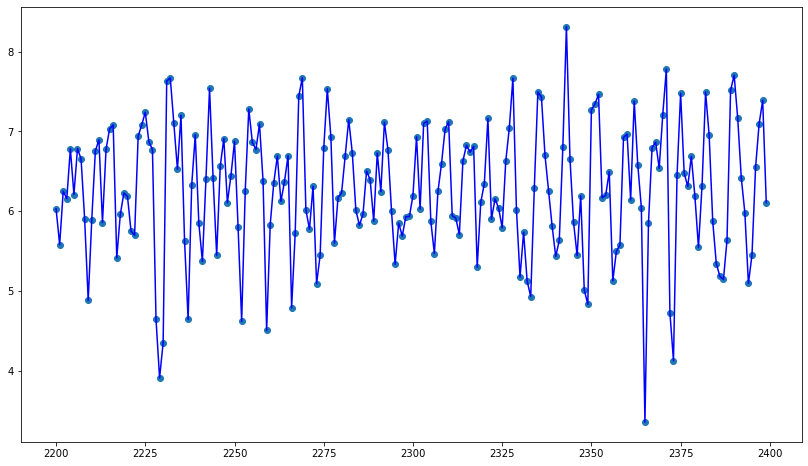

In [297]:
plt.figure(figsize=(14, 8))
plt.plot(np.arange(2200, 2400), sim[2200:2400], 'o')
plt.plot(np.arange(2200, 2400), sim[2200:2400], 'b')
plt.show()

In [298]:
TT = test_dfs[0]['value']

In [312]:
import DAMP_V2
reload(DAMP_V2)
from DAMP_V2 import DAMP_V2

In [315]:
damp1 = DAMP_V2({"lookahead": 1000, "enable_output": True})
scor1, pos1, left_MP1 = damp1.DAMP_2_0(TT, 20, 2000)

-----------------------------------------------
Thank you for using DAMP.
This is version 2.0 of DAMP, please email Eamonn Keogh (eamonn@cs.ucr.edu) or Yue Lu (ylu175@ucr.edu) to make sure you have the latest version.
This time series is of length 13249, and the subsequence length is 20
The lookahead modified from 1000 to the next power of 2: 1024.
Hints:
Usually, the subsequence length you should use is between about 50 to 90% of a typical period.
A good initial value of lookahead is about 2^nearest_power_of_two(16 times S).
The range of lookahead should be 0 to length(T)-location_to_start_processing.
If speed is important, you can tune lookahead to get greater speed-up in your domain.
A simple search, doubling and halving the current value,
 should let you quickly converge on a good value.
------------------------------------------


Results:
DAMP_V2 run time 0:13:09.996897
Pruning Rate: 0.6956366874443455
Predicted discord score/position: 4.037910347804943 / [2969]


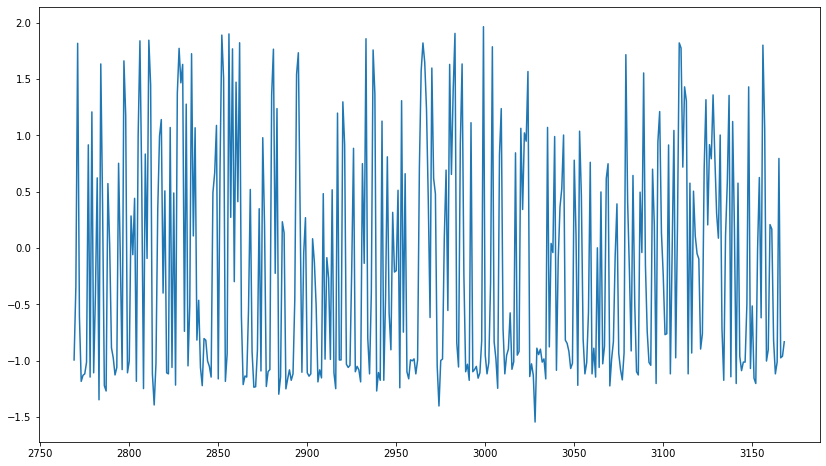

In [323]:
plt.figure(figsize=(14, 8))
plt.plot(np.arange(pos1[0]-200, pos1[0]+200), TT[pos1[0]-200:pos1[0]+200])
plt.show()

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(np.arange(pos1-200, pos1+200), left_MP1[pos1-200:pos1+200])
plt.show()

In [303]:
scor, pos, left_MP = damp.DAMP_2_0(TT, 20, 10000)

-----------------------------------------------
Thank you for using DAMP.
This is version 2.0 of DAMP, please email Eamonn Keogh (eamonn@cs.ucr.edu) or Yue Lu (ylu175@ucr.edu) to make sure you have the latest version.
This time series is of length 13249, and the subsequence length is 20
The lookahead modified from 1024 to the next power of 2: 1024.
Hints:
Usually, the subsequence length you should use is between about 50 to 90% of a typical period.
A good initial value of lookahead is about 2^nearest_power_of_two(16 times S).
The range of lookahead should be 0 to length(T)-location_to_start_processing.
If speed is important, you can tune lookahead to get greater speed-up in your domain.
A simple search, doubling and halving the current value,
 should let you quickly converge on a good value.
------------------------------------------


Results:
DAMP_V2 run time 0:16:41.871480
Pruning Rate: 0.4501547987616099
Predicted discord score/position: 3.7305603582478533 / [11557]


In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(np.arange(pos-200, pos+200), TT[pos-200:pos+200])
plt.show()

In [319]:
plt.figure(figsize=(14, 8))
plt.plot(np.arange(pos-200, pos+200), left_MP[pos-200:pos+200])
plt.show()

TypeError: only integer scalar arrays can be converted to a scalar index

<Figure size 1008x576 with 0 Axes>

In [314]:
damp3 = DAMP_V2({"lookahead": 1000, "enable_output": True})
scor3, pos3, left_MP3 = damp3.DAMP_2_0(TT, 20, 12000)

-----------------------------------------------
Thank you for using DAMP.
This is version 2.0 of DAMP, please email Eamonn Keogh (eamonn@cs.ucr.edu) or Yue Lu (ylu175@ucr.edu) to make sure you have the latest version.
This time series is of length 13249, and the subsequence length is 20
The lookahead modified from 1000 to the next power of 2: 1024.
Hints:
Usually, the subsequence length you should use is between about 50 to 90% of a typical period.
A good initial value of lookahead is about 2^nearest_power_of_two(16 times S).
The range of lookahead should be 0 to length(T)-location_to_start_processing.
If speed is important, you can tune lookahead to get greater speed-up in your domain.
A simple search, doubling and halving the current value,
 should let you quickly converge on a good value.
------------------------------------------


Results:
DAMP_V2 run time 0:14:22.566749
Pruning Rate: 0.2731707317073171
Predicted discord score/position: 3.5489145646968137 / [12618]


In [316]:
damp4 = DAMP_V2({"lookahead": 1000, "enable_output": True})
scor4, pos4, left_MP4 = damp4.DAMP_2_0(TT, 20, 7000)

-----------------------------------------------
Thank you for using DAMP.
This is version 2.0 of DAMP, please email Eamonn Keogh (eamonn@cs.ucr.edu) or Yue Lu (ylu175@ucr.edu) to make sure you have the latest version.
This time series is of length 13249, and the subsequence length is 20
The lookahead modified from 1000 to the next power of 2: 1024.
Hints:
Usually, the subsequence length you should use is between about 50 to 90% of a typical period.
A good initial value of lookahead is about 2^nearest_power_of_two(16 times S).
The range of lookahead should be 0 to length(T)-location_to_start_processing.
If speed is important, you can tune lookahead to get greater speed-up in your domain.
A simple search, doubling and halving the current value,
 should let you quickly converge on a good value.
------------------------------------------


Results:
DAMP_V2 run time 0:21:18.466908
Pruning Rate: 0.515569823434992
Predicted discord score/position: 3.7999497376908367 / [8767]


In [109]:
len(left_MP)

2888

In [110]:
max(left_MP)

4.825567862541175

In [111]:
max_mp = np.where(left_MP == max(left_MP))
print(max_mp[0])

[161]


In [112]:
left_MP[161]

4.825567862541175

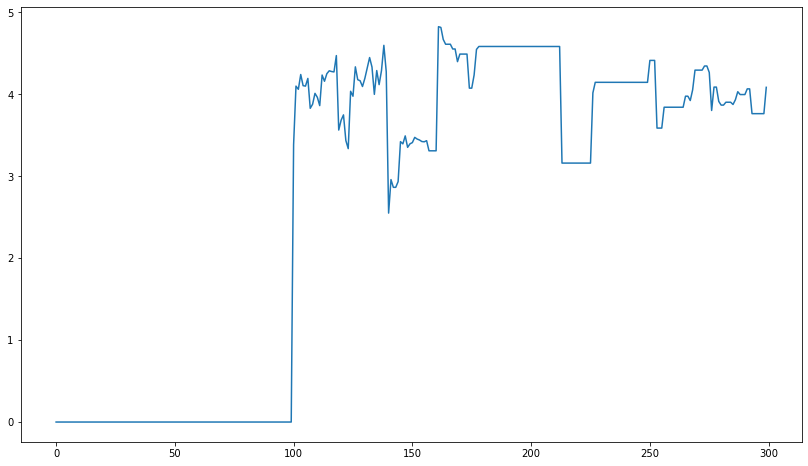

In [114]:
plt.figure(figsize=(14, 8))
plt.plot(np.arange(0, 300), left_MP[:300])
plt.show()

In [115]:
maxa = np.where(left_MP > 4.6)
print(maxa)

(array([ 161,  162,  163,  164,  165,  166,  764, 1117, 1118, 2518],
      dtype=int64),)


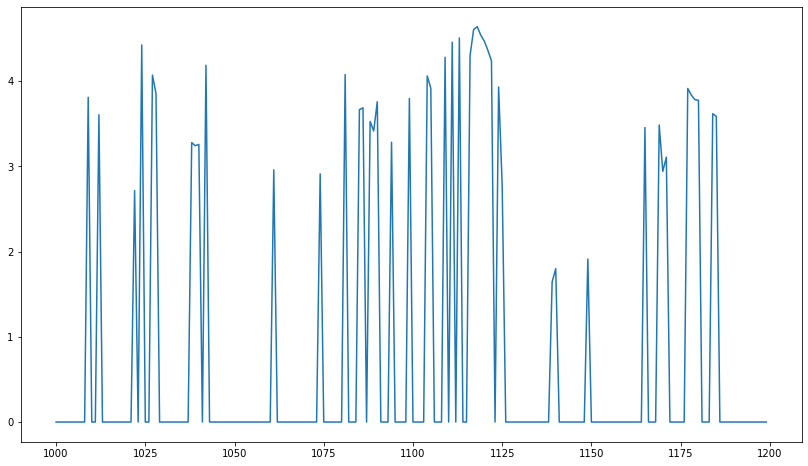

In [118]:
plt.figure(figsize=(14, 8))
plt.plot(np.arange(1000, 1200), left_MP[1000:1200])
plt.show()

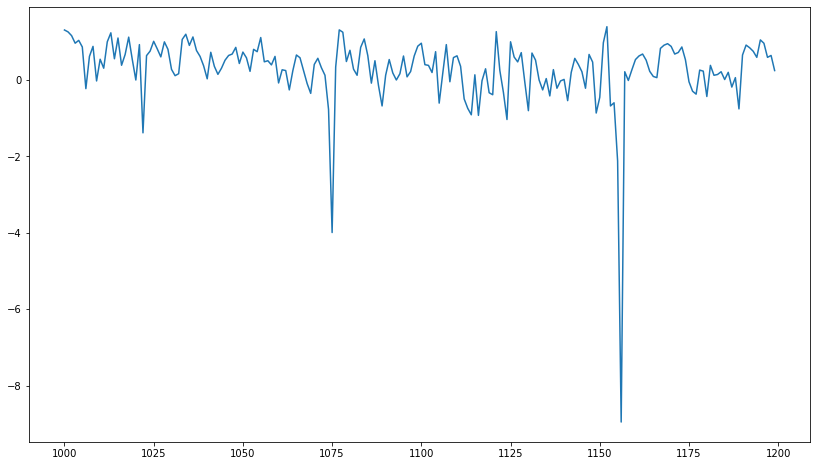

In [119]:
plt.figure(figsize=(14, 8))
plt.plot(np.arange(1000, 1200), TT[1000:1200])
plt.show()

In [413]:
zz = np.zeros(4)
yy = zz.copy()

In [418]:
yy[2:4] = 4

In [419]:
yy

array([0., 0., 4., 4.])

In [157]:
rng = pd.date_range('1/1/2023 00:00:00', periods=122, freq='1s')

In [158]:
rng

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 00:00:01',
               '2023-01-01 00:00:02', '2023-01-01 00:00:03',
               '2023-01-01 00:00:04', '2023-01-01 00:00:05',
               '2023-01-01 00:00:06', '2023-01-01 00:00:07',
               '2023-01-01 00:00:08', '2023-01-01 00:00:09',
               ...
               '2023-01-01 00:01:52', '2023-01-01 00:01:53',
               '2023-01-01 00:01:54', '2023-01-01 00:01:55',
               '2023-01-01 00:01:56', '2023-01-01 00:01:57',
               '2023-01-01 00:01:58', '2023-01-01 00:01:59',
               '2023-01-01 00:02:00', '2023-01-01 00:02:01'],
              dtype='datetime64[ns]', length=122, freq='S')

In [159]:
rng.floor('1min')

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 00:00:00',
               '2023-01-01 00:00:00', '2023-01-01 00:00:00',
               '2023-01-01 00:00:00', '2023-01-01 00:00:00',
               '2023-01-01 00:00:00', '2023-01-01 00:00:00',
               '2023-01-01 00:00:00', '2023-01-01 00:00:00',
               ...
               '2023-01-01 00:01:00', '2023-01-01 00:01:00',
               '2023-01-01 00:01:00', '2023-01-01 00:01:00',
               '2023-01-01 00:01:00', '2023-01-01 00:01:00',
               '2023-01-01 00:01:00', '2023-01-01 00:01:00',
               '2023-01-01 00:02:00', '2023-01-01 00:02:00'],
              dtype='datetime64[ns]', length=122, freq=None)

In [328]:
from scipy import signal
from scipy.signal import find_peaks

In [348]:
def xcorr(ts, max_lag=3000):
    corr = signal.correlate(ts, ts, mode="full")
    lags = signal.correlation_lags(max_lag, max_lag, mode="full")
    return corr, lags

In [391]:
def find_max_peak_index(autocor, lags):
    idx = find_peaks(autocor)[0]
    new_corr = np.take(autocor, idx)
    i = np.argmax(new_corr)
    j = idx[i]
    return lags[j]

In [343]:
2*len(TT)

26498

In [394]:
corr, lag = xcorr(TT)

In [395]:
print(len(corr))
print(len(lag))

26497
5999


In [406]:
corr[len(TT)-3]

-302.4702356283965

In [392]:
corr

array([-2.87287294, -1.69599433,  5.06407926, ...,  5.06407926,
       -1.69599433, -2.87287294])

In [410]:
kk = np.corrcoef(TT, TT)
print(np.max(kk))

1.0


In [408]:
TT

0        1.952409
1        1.074625
2       -0.856609
3        1.027295
4        0.832505
           ...   
13244    0.433680
13245    1.401911
13246    1.980515
13247   -0.058767
13248   -1.471451
Name: value, Length: 13249, dtype: float64

In [393]:
find_max_peak_index(corr[3010:4001], lag[3010:4001])

398

In [354]:
lag[3000:3011]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [341]:
corr[2998:3002]

array([ -97.11039964,  -11.99811549,  -95.6456749 , -173.81098317])

In [360]:
corr_s = corr[3010:4001]

In [359]:
idx = find_max_peak_index(corr_s)

In [385]:
new_corr = np.take(corr_s, idx[0])
print(len(new_corr))
print(len(idx[0]))

288
288


In [386]:
np.argmax(new_corr)

106

In [387]:
idx[0][106]

387

In [389]:
corr_s[380:395]

array([  -7.65120102,  -77.77450709,  -49.02780922,  -49.06664375,
       -115.40926664, -144.53149682,  -76.95855061,  156.60779089,
         -6.99363132,   -5.67394997,  -79.85209917,  -28.1578632 ,
        -95.30584222,   16.08539082,   54.86963354])

In [390]:
corr_s[387]

156.60779088558968

In [326]:
TT

0        1.952409
1        1.074625
2       -0.856609
3        1.027295
4        0.832505
           ...   
13244    0.433680
13245    1.401911
13246    1.980515
13247   -0.058767
13248   -1.471451
Name: value, Length: 13249, dtype: float64

In [438]:
import DAMP_topK
reload(DAMP_topK)
from DAMP_topK import DAMP_topK

In [439]:
damp_topk = DAMP_topK(enable_print=True)

In [440]:
damp_topk.DAMP_k(TT, 10)

Auto subsequence length set to 398.
Starting from index 1001, with lookahead of 1024
Prefix handled starting.
left_MP iteration 1001 out of 7369
left_MP iteration 1002 out of 7369
left_MP iteration 1003 out of 7369
left_MP iteration 1004 out of 7369
left_MP iteration 1005 out of 7369
left_MP iteration 1006 out of 7369
left_MP iteration 1007 out of 7369
left_MP iteration 1008 out of 7369
left_MP iteration 1009 out of 7369
left_MP iteration 1010 out of 7369
left_MP iteration 1011 out of 7369
left_MP iteration 1012 out of 7369
left_MP iteration 1013 out of 7369
left_MP iteration 1014 out of 7369
left_MP iteration 1015 out of 7369
left_MP iteration 1016 out of 7369
left_MP iteration 1017 out of 7369
left_MP iteration 1018 out of 7369
left_MP iteration 1019 out of 7369
left_MP iteration 1020 out of 7369
left_MP iteration 1021 out of 7369
left_MP iteration 1022 out of 7369
left_MP iteration 1023 out of 7369
left_MP iteration 1024 out of 7369
left_MP iteration 1025 out of 7369
left_MP iterati

KeyboardInterrupt: 